LP qubit routing creation


We start with one simple change of the variables integrality. 

Okay, let's now create a simple non broken circuit, and see what will happen with the result. 

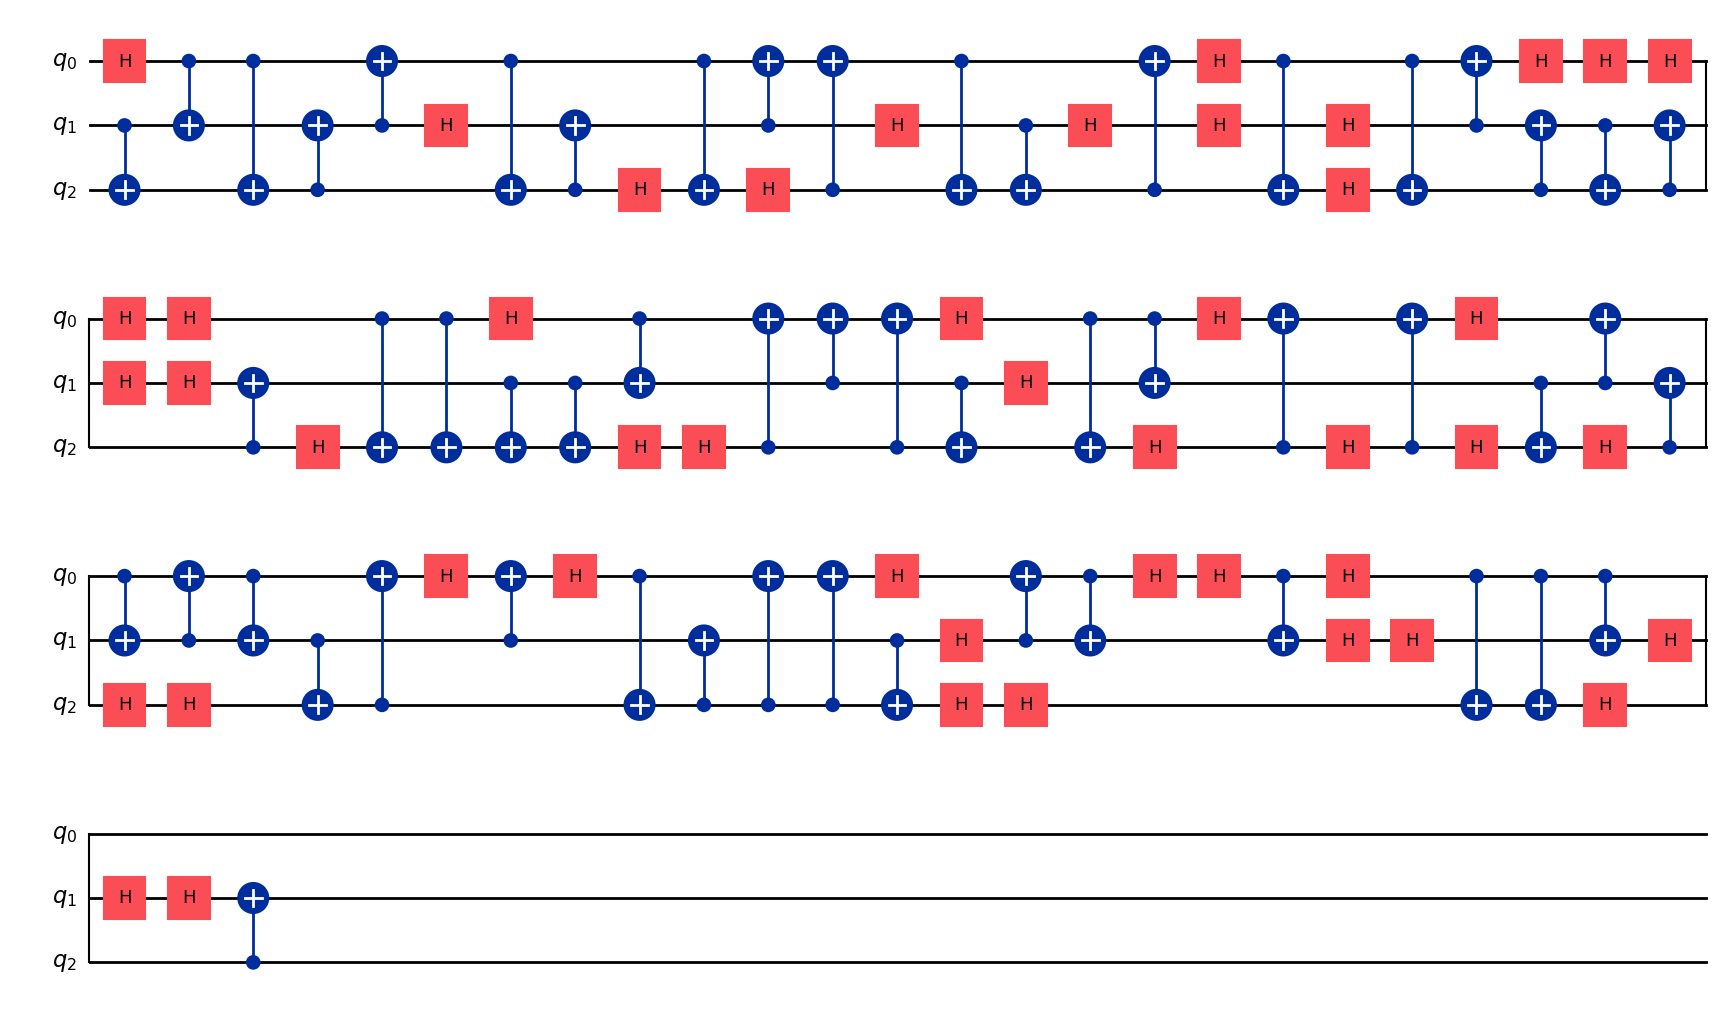

In [2]:
import qiskit.circuit.random
import qiskit
import qiskit.circuit.library.standard_gates
import random

import quariadne.circuit
QUBIT_COUNT = 3
NUM_GATES = 100
SEED=2277
random.seed(SEED)

MAX_OPERANDS = 2

STANDARD_GATE_SET = ["cx", "h"]



random_broken_circuit = qiskit.circuit.random.random_clifford_circuit(QUBIT_COUNT, NUM_GATES, STANDARD_GATE_SET, seed=SEED)

random_broken_circuit.draw('mpl')

Now let's generate random backend coupling map)

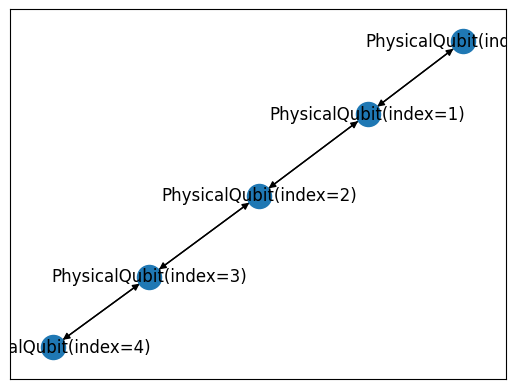

In [3]:
import qiskit_ibm_runtime.fake_provider 
import networkx as nx

manila_backend = qiskit_ibm_runtime.fake_provider.FakeManilaV2()
coupling_graph = manila_backend.coupling_map.graph
coupling_graph_nx = nx.DiGraph()

coupling_map_qubits = manila_backend.coupling_map.physical_qubits
physical_qubits = tuple(quariadne.circuit.PhysicalQubit(coupling_map_qubit) for coupling_map_qubit in coupling_map_qubits)
coupling_map_edgelist = manila_backend.coupling_map.graph.edge_list()
physical_qubits_connections = tuple((quariadne.circuit.PhysicalQubit(coupling_map_from), quariadne.circuit.PhysicalQubit(coupling_map_to)) for coupling_map_from, coupling_map_to in coupling_map_edgelist)
physical_qubits, physical_qubits_connections
coupling_graph_nx.add_nodes_from(physical_qubits)
coupling_graph_nx.add_edges_from(physical_qubits_connections)
nx.draw_networkx(coupling_graph_nx)

Finally, let's see an encapsulated version of the ciurcuti

In [4]:
random_abstract_circuit = quariadne.circuit.AbstractQuantumCircuit.from_qiskit_circuit(random_broken_circuit)
random_abstract_circuit.operations

[QuantumOperation(name='cx', qubits_participating=(LogicalQubit(index=1), LogicalQubit(index=2))),
 QuantumOperation(name='h', qubits_participating=(LogicalQubit(index=0),)),
 QuantumOperation(name='cx', qubits_participating=(LogicalQubit(index=0), LogicalQubit(index=1))),
 QuantumOperation(name='cx', qubits_participating=(LogicalQubit(index=0), LogicalQubit(index=2))),
 QuantumOperation(name='cx', qubits_participating=(LogicalQubit(index=2), LogicalQubit(index=1))),
 QuantumOperation(name='cx', qubits_participating=(LogicalQubit(index=1), LogicalQubit(index=0))),
 QuantumOperation(name='h', qubits_participating=(LogicalQubit(index=1),)),
 QuantumOperation(name='cx', qubits_participating=(LogicalQubit(index=0), LogicalQubit(index=2))),
 QuantumOperation(name='cx', qubits_participating=(LogicalQubit(index=2), LogicalQubit(index=1))),
 QuantumOperation(name='h', qubits_participating=(LogicalQubit(index=2),)),
 QuantumOperation(name='cx', qubits_participating=(LogicalQubit(index=0), Logic

Let's initialise the milp router, and run it then!

In [5]:
import quariadne.milp_router

lp_router = quariadne.milp_router.MilpRouter(coupling_graph_nx, random_abstract_circuit, 0)
lp_router_result = lp_router.run()
lp_router_result

        message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
        success: True
         status: 0
            fun: 0.0
              x: [ 8.571e-02  3.429e-01 ...  0.000e+00  7.429e-01]
 mip_node_count: None
 mip_dual_bound: None
        mip_gap: None


MilpRouterResult(milp_result=        message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
        success: True
         status: 0
            fun: 0.0
              x: [ 8.571e-02  3.429e-01 ...  0.000e+00  7.429e-01]
 mip_node_count: None
 mip_dual_bound: None
        mip_gap: None, mapping_variables=array([[[ 0.08571429,  0.34285714,  0.17142857,  0.4       ,
         -0.        ],
        [ 0.34285714,  0.34285714,  0.08571429,  0.22857143,
         -0.        ],
        [ 0.14285714,  0.14285714,  0.34285714,  0.37142857,
         -0.        ],
        [ 0.42857143,  0.17142857,  0.14285714, -0.        ,
          0.25714286],
        [-0.        , -0.        ,  0.25714286, -0.        ,
          0.74285714]],

       [[ 0.08571429,  0.34285714,  0.17142857,  0.4       ,
         -0.        ],
        [ 0.34285714,  0.34285714,  0.08571429,  0.22857143,
         -0.        ],
        [ 0.14285714,  0.14285714,  0.34285714,  0.37142857,
         -0.        ],
  

Great, now let's check them out more in-depth. 

In [6]:
lp_router_result.mapping_variables[0]

array([[ 0.08571429,  0.34285714,  0.17142857,  0.4       , -0.        ],
       [ 0.34285714,  0.34285714,  0.08571429,  0.22857143, -0.        ],
       [ 0.14285714,  0.14285714,  0.34285714,  0.37142857, -0.        ],
       [ 0.42857143,  0.17142857,  0.14285714, -0.        ,  0.25714286],
       [-0.        , -0.        ,  0.25714286, -0.        ,  0.74285714]])

In [7]:
from birkhoff import birkhoff_von_neumann_decomposition
import numpy as np



result = birkhoff_von_neumann_decomposition(lp_router_result.mapping_variables[0])
permutation_by_coefficient = dict()
for coefficient, permutation_matrix in result:
    permutation_by_coefficient[coefficient] = permutation_matrix[np.newaxis, ...]

permutation_by_coefficient, lp_router_result.mapping_variables[0], lp_router_result.gate_execution_variables[0]

({np.float64(0.08571428571428596): array([[[1., 0., 0., 0., 0.],
          [0., 1., 0., 0., 0.],
          [0., 0., 0., 1., 0.],
          [0., 0., 0., 0., 1.],
          [0., 0., 1., 0., 0.]]]),
  np.float64(0.1714285714285716): array([[[0., 1., 0., 0., 0.],
          [1., 0., 0., 0., 0.],
          [0., 0., 0., 1., 0.],
          [0., 0., 0., 0., 1.],
          [0., 0., 1., 0., 0.]]]),
  np.float64(0.17142857142857193): array([[[0., 1., 0., 0., 0.],
          [0., 0., 0., 1., 0.],
          [0., 0., 1., 0., 0.],
          [1., 0., 0., 0., 0.],
          [0., 0., 0., 0., 1.]]]),
  np.float64(0.05714285714285661): array([[[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.],
          [0., 1., 0., 0., 0.],
          [1., 0., 0., 0., 0.],
          [0., 0., 0., 0., 1.]]]),
  np.float64(0.11428571428571066): array([[[0., 0., 1., 0., 0.],
          [1., 0., 0., 0., 0.],
          [0., 0., 0., 1., 0.],
          [0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1.]]]),
  np.float64(0.057142

In [11]:

lp_router = quariadne.milp_router.MilpRouter(coupling_graph_nx, random_abstract_circuit, 0, permutation_by_coefficient[np.float64(0.1714285714285746)])
lp_router_result = lp_router.run()
lp_router_result

(0, np.int64(0), np.int64(3))
(0, np.int64(1), np.int64(1))
(0, np.int64(2), np.int64(2))
(0, np.int64(3), np.int64(0))
(0, np.int64(4), np.int64(4))
<Compressed Sparse Row sparse array of dtype 'float64'
	with 5 stored elements and shape (5, 282852)>
  Coords	Values
  (0, 3)	1.0
  (1, 6)	1.0
  (2, 12)	1.0
  (3, 15)	1.0
  (4, 24)	1.0
        message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
        success: True
         status: 0
            fun: 1.0000000000000009
              x: [-0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]
 mip_node_count: None
 mip_dual_bound: None
        mip_gap: None


MilpRouterResult(milp_result=        message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
        success: True
         status: 0
            fun: 1.0000000000000009
              x: [-0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]
 mip_node_count: None
 mip_dual_bound: None
        mip_gap: None, mapping_variables=array([[[-0. ,  0. ,  0. ,  1. ,  0. ],
        [-0. ,  1. ,  0. ,  0. ,  0. ],
        [-0. ,  0. ,  1. ,  0. ,  0. ],
        [ 1. , -0. , -0. ,  0. ,  0. ],
        [ 0. ,  0. , -0. ,  0. ,  1. ]],

       [[-0. , -0. , -0. ,  1. , -0. ],
        [-0. ,  0.5,  0.5,  0. , -0. ],
        [ 0. ,  0.5,  0.5,  0. , -0. ],
        [ 1. , -0. ,  0. ,  0. , -0. ],
        [-0. , -0. , -0. , -0. ,  1. ]],

       [[-0. , -0. , -0. ,  1. , -0. ],
        [-0. ,  0.5,  0.5, -0. , -0. ],
        [-0. ,  0.5,  0.5,  0. , -0. ],
        [ 1. , -0. , -0. , -0. , -0. ],
        [-0. , -0. , -0. ,  0. ,  1. ]],

       ...,

       [[-0. , -0. , -0. ,  1. , -0. ],
  

And let's check the first permutation then.. 

In [13]:
(lp_router_result.gate_execution_variables[9]), coupling_graph_nx.edges, np.argwhere(lp_router_result.mapping_variables[0])

(array([[ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
        [-0. , -0. , -0. ,  0.5,  0.5, -0. , -0. , -0. ],
        [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
        [ 0. ,

In [14]:
result = birkhoff_von_neumann_decomposition(lp_router_result.gate_execution_variables[0])
for coefficient, permutation_matrix in result:
    print('coefficient:', coefficient)
    print('permutation matrix:', permutation_matrix)

np.argwhere(result[-1][1]) 

ValueError: Input matrix must be square (54 x 8)

In [18]:
defined_movements = np.argwhere(lp_router_result.qubit_movement_variables)
for movement in defined_movements:

    timesteps, logical_qubit, from_qubit, to_qubit = movement
    if from_qubit != to_qubit:
        print(timesteps, logical_qubit, from_qubit, to_qubit, lp_router_result.qubit_movement_variables[timesteps, logical_qubit, from_qubit, to_qubit])
        


0 1 1 2 0.5000000000000004
0 2 2 1 0.5000000000000004
5 0 3 2 0.5000000000000004
5 1 2 3 0.5000000000000004


In [16]:
lp_router_result.qubit_movement_variables[0].s

(5, 5, 5)

Okay, after all of these experiments, let's design a chooser phase first. For an initial mapping, we just sample a biggest placement from a gate execution array, and then find a compatible mapping for that. 

In [21]:
lp_router = quariadne.milp_router.MilpRouter(coupling_graph_nx, random_abstract_circuit, 0)
lp_router_result = lp_router.run()
lp_router_result

        message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
        success: True
         status: 0
            fun: 0.0
              x: [ 8.571e-02  3.429e-01 ...  0.000e+00  7.429e-01]
 mip_node_count: None
 mip_dual_bound: None
        mip_gap: None


MilpRouterResult(milp_result=        message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
        success: True
         status: 0
            fun: 0.0
              x: [ 8.571e-02  3.429e-01 ...  0.000e+00  7.429e-01]
 mip_node_count: None
 mip_dual_bound: None
        mip_gap: None, mapping_variables=array([[[ 0.08571429,  0.34285714,  0.17142857,  0.4       ,
         -0.        ],
        [ 0.34285714,  0.34285714,  0.08571429,  0.22857143,
         -0.        ],
        [ 0.14285714,  0.14285714,  0.34285714,  0.37142857,
         -0.        ],
        [ 0.42857143,  0.17142857,  0.14285714, -0.        ,
          0.25714286],
        [-0.        , -0.        ,  0.25714286, -0.        ,
          0.74285714]],

       [[ 0.08571429,  0.34285714,  0.17142857,  0.4       ,
         -0.        ],
        [ 0.34285714,  0.34285714,  0.08571429,  0.22857143,
         -0.        ],
        [ 0.14285714,  0.14285714,  0.34285714,  0.37142857,
         -0.        ],
  

Now we get a decomposition, and a target edge. 

In [39]:
import networkx as nx

result = birkhoff_von_neumann_decomposition(lp_router_result.mapping_variables[0])
permutation_by_coefficient = dict()
for coefficient, permutation_matrix in result:
    permutation_by_coefficient[coefficient] = permutation_matrix[np.newaxis, ...]
sorted_permutations = sorted(permutation_by_coefficient.items(), reverse=True)
target_edge_index = np.argmax(lp_router_result.gate_execution_variables[0])
target_edge = list(coupling_graph_nx.edges())[target_edge_index]
physical_left, physical_right = target_edge

chosen_permutation = permutation_matrix
for coefficient, permutation_matrix in sorted_permutations:
    current_connectivity = nx.from_numpy_array(permutation_matrix[0])
    if current_connectivity.has_edge(physical_left.index, physical_right.index):
        chosen_permutation = permutation_matrix
        break

chosen_permutation

array([[[0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1.]]])

Now let's run it in the router to be sure it works as we want it to work. 

In [40]:
lp_router = quariadne.milp_router.MilpRouter(coupling_graph_nx, random_abstract_circuit, 0, chosen_permutation)
lp_router_result = lp_router.run()
lp_router_result

(0, np.int64(0), np.int64(3))
(0, np.int64(1), np.int64(0))
(0, np.int64(2), np.int64(1))
(0, np.int64(3), np.int64(2))
(0, np.int64(4), np.int64(4))
<Compressed Sparse Row sparse array of dtype 'float64'
	with 5 stored elements and shape (5, 282852)>
  Coords	Values
  (0, 3)	1.0
  (1, 5)	1.0
  (2, 11)	1.0
  (3, 17)	1.0
  (4, 24)	1.0
        message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
        success: True
         status: 0
            fun: 1.0
              x: [ 0.000e+00  0.000e+00 ...  0.000e+00  9.000e-01]
 mip_node_count: None
 mip_dual_bound: None
        mip_gap: None


MilpRouterResult(milp_result=        message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
        success: True
         status: 0
            fun: 1.0
              x: [ 0.000e+00  0.000e+00 ...  0.000e+00  9.000e-01]
 mip_node_count: None
 mip_dual_bound: None
        mip_gap: None, mapping_variables=array([[[ 0. ,  0. ,  0. ,  1. , -0. ],
        [ 1. ,  0. ,  0. ,  0. , -0. ],
        [ 0. ,  1. ,  0. , -0. ,  0. ],
        [ 0. ,  0. ,  1. , -0. ,  0. ],
        [-0. , -0. ,  0. , -0. ,  1. ]],

       [[-0. , -0. , -0. ,  1. , -0. ],
        [ 1. , -0. , -0. , -0. , -0. ],
        [-0. ,  1. , -0. , -0. , -0. ],
        [-0. , -0. ,  1. , -0. ,  0. ],
        [-0. , -0. , -0. , -0. ,  1. ]],

       [[-0. , -0. , -0. ,  1. , -0. ],
        [ 0.8,  0.2, -0. , -0. , -0. ],
        [ 0.2,  0.8, -0. ,  0. , -0. ],
        [-0. , -0. ,  1. , -0. ,  0. ],
        [-0. , -0. , -0. , -0. ,  1. ]],

       ...,

       [[-0. , -0. , -0. ,  1. , -0. ],
        [ 0.6,  0

In [41]:
defined_movements = np.argwhere(lp_router_result.qubit_movement_variables)
for movement in defined_movements:

    timesteps, logical_qubit, from_qubit, to_qubit = movement
    if from_qubit != to_qubit:
        print(timesteps, logical_qubit, from_qubit, to_qubit, lp_router_result.qubit_movement_variables[timesteps, logical_qubit, from_qubit, to_qubit])
        


1 0 1 2 0.20000000000000917
1 1 2 1 0.20000000000000917
2 1 2 3 -1.509903313490213e-14
2 2 3 2 -1.509903313490213e-14
5 2 3 2 1.509903313490213e-14
5 2 3 4 0.09999999999998344
5 4 4 3 0.09999999999998344
6 1 2 3 0.20000000000000917
6 2 3 2 0.20000000000000917
8 0 1 2 -1.509903313490213e-14
8 1 2 3 -1.509903313490213e-14
9 2 2 1 1.509903313490213e-14
10 0 1 2 1.509903313490213e-14
10 0 2 3 1.509903313490213e-14
11 0 1 2 0.19999999999999407
11 2 2 1 0.19999999999999407
13 1 2 3 0.2000000000000226
13 2 3 2 0.2000000000000226
14 0 2 3 0.09999999999996834
14 2 3 2 0.09999999999996834
17 0 1 0 1.3211653993039363e-14
17 3 0 1 1.3211653993039363e-14
26 4 1 0 1.837419105754634e-14
27 4 1 0 -1.837419105754634e-14
